<a href="https://colab.research.google.com/github/JoWillS12/ComVis/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#2. Constant and Load DenseNet

In [14]:
# Constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
NUM_CLASSES = 16  # Number of flower classes
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Load DenseNet121 pre-trained on ImageNet
base_model = DenseNet121(
    weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
)

#3. Layers And Model


In [15]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the DenseNet121 model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


#4. Load Data

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Load and preprocess data
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/COMVIS2023/flowers 2',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/COMVIS2023/flowers 2',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/COMVIS2023/flowers 2',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 12701 images belonging to 16 classes.
Found 3166 images belonging to 16 classes.
Found 15867 images belonging to 16 classes.


#5. Train and Testing



In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS
)

# Save the trained model
model.save('flower_classification_model.h5')

# Load the saved model
loaded_model = load_model('flower_classification_model.h5')

# Print the loaded model summary
loaded_model.summary()

Epoch 1/10
396/396 [==============================] - 78s 179ms/step - loss: 0.5466 - accuracy: 0.8312 - val_loss: 0.3844 - val_accuracy: 0.8811
Epoch 2/10
396/396 [==============================] - 77s 193ms/step - loss: 0.2596 - accuracy: 0.9161 - val_loss: 0.3017 - val_accuracy: 0.9069
Epoch 3/10
396/396 [==============================] - 79s 199ms/step - loss: 0.1917 - accuracy: 0.9382 - val_loss: 0.3051 - val_accuracy: 0.9018
Epoch 4/10
396/396 [==============================] - 68s 173ms/step - loss: 0.1574 - accuracy: 0.9471 - val_loss: 0.2693 - val_accuracy: 0.9209
Epoch 5/10
396/396 [==============================] - 71s 178ms/step - loss: 0.1227 - accuracy: 0.9608 - val_loss: 0.2993 - val_accuracy: 0.9110
Epoch 6/10
396/396 [==============================] - 79s 198ms/step - loss: 0.0972 - accuracy: 0.9677 - val_loss: 0.3223 - val_accuracy: 0.9094
Epoch 7/10
396/396 [==============================] - 75s 190ms/step - loss: 0.0787 - accuracy: 0.9750 - val_loss: 0.3842 - val_ac

496/496 [==============================] - 72s 139ms/step


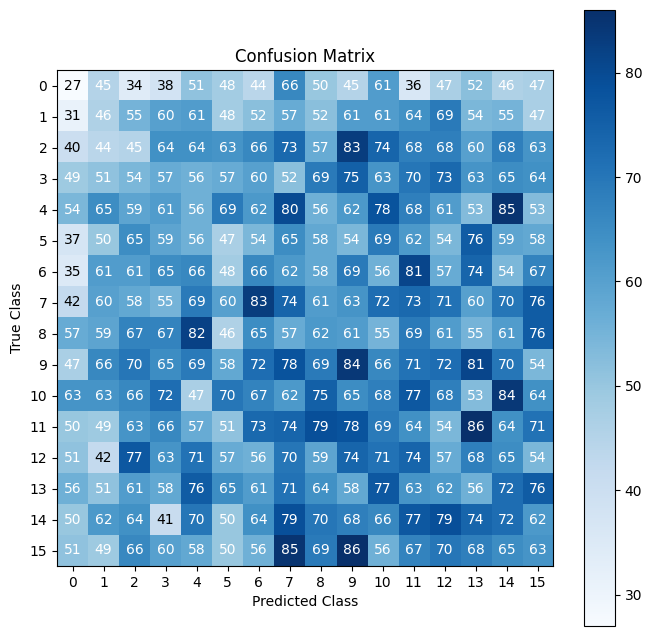

In [19]:
# Evaluate the model on the test set
predictions = loaded_model.predict(test_generator)
y_true = test_generator.classes[:predictions.shape[0]]  # Adjust the length of y_true
y_pred = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, range(NUM_CLASSES))
plt.yticks(tick_marks, range(NUM_CLASSES))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add labels to each cell
thresh = cm.max() / 2.0
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()


#6. Result



In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

495/495 [==============================] - 71s 140ms/step - loss: 0.0891 - accuracy: 0.9770
Test Loss: 0.08912297338247299
Test Accuracy: 0.9770202040672302


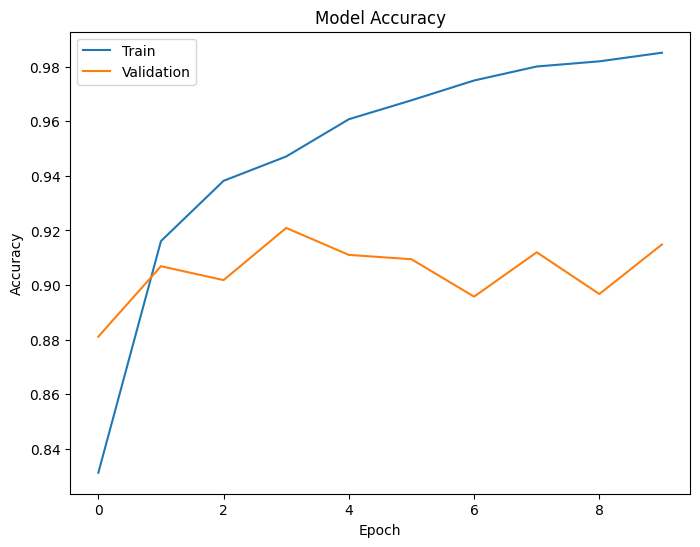

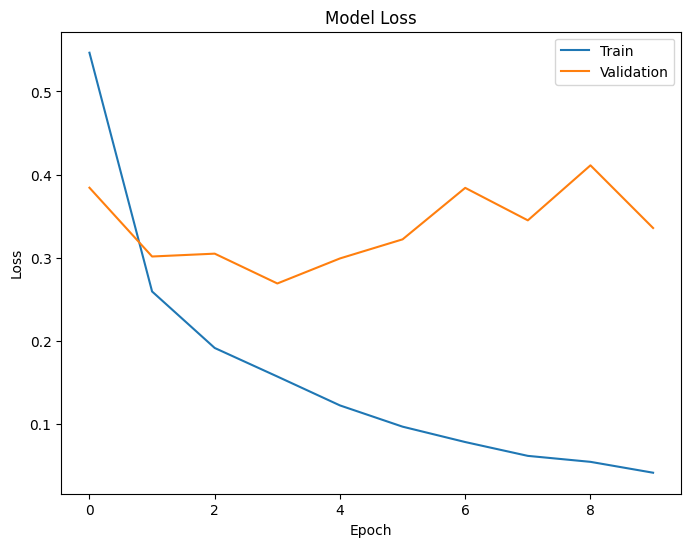

In [21]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()